https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-3.lstm-post/
- 한 시간 간격으로 측정 되어 있는 한 달치 특정 구간의 평균 속도 데이터를 이용하여 마지막 일주일 간의 평균 속도를 예측하는 task

## Encoder-Decoder LSTM (=seq2seq)
- 장단기 기억(LSTM) 신경망을 사용하여 시계열 데이터를 전망
- 시퀀스의 미래의 시간 스텝 값을 전망하기 위해 응답 변수가 값이 시간 스텝 하나만큼 이동된 훈련 시퀀스인 sequence-to-sequence 회귀 LSTM 신경망을 훈련
- LSTM 신경망은 입력 시퀀스의 각 시간 스텝마다 다음 시간 스텝의 값을 예측하도록 학습

#### 1. Load Data

In [78]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange     #  작업진행률 표시
import random

,Unnamed: 0,집계일시,평균속도
0,0,2021050100,98.63
1,1,2021050101,100.53
2,2,2021050102,99.86
3,3,2021050103,99.34
4,4,2021050104,93.64


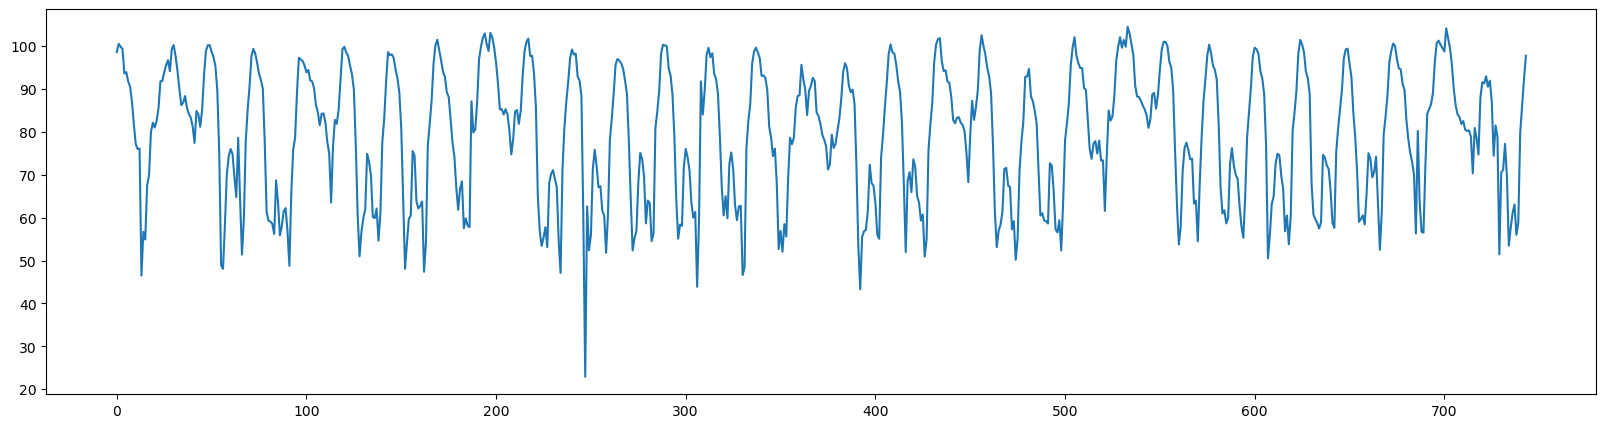

In [79]:
data = pd.read_csv("서인천IC-부평IC 평균속도.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(range(len(data)), data["평균속도"])
data.head()         # 년, 월, 일, 시 가 있는 column과 평균속도의 값이 있는 column

#### 2. Data Preprocessing

In [80]:
data = data.drop(columns='Unnamed: 0')

In [81]:
data

,집계일시,평균속도
0,2021050100,98.63
1,2021050101,100.53
2,2021050102,99.86
3,2021050103,99.34
4,2021050104,93.64
...,...,...
739,2021053119,58.86
740,2021053120,79.86
741,2021053121,86.01
742,2021053122,92.28


- 스케일을 조정하는 정규화 함수 sklearn의 MinMaxScaler

In [82]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()             # sklearn의 MinMaxScaler를 사용하여 데이터의 범위를 0~1로 만들어준다.
data["평균속도"] = min_max_scaler.fit_transform(data["평균속도"].to_numpy().reshape(-1,1))      # 스케일을 조정하는 정규화 함수

- 마지막 일주일의 데이터를 예측하는 것이 목표이므로 train, test set을 마지막 일주일을 기준으로 나눠준

In [83]:
train = data[:-24*7]
train = train["평균속도"].to_numpy()

test = data[-24*7:]
test = test["평균속도"].to_numpy()

In [84]:
train

array([0.92784515, 0.95112091, 0.94291314, 0.93654294, 0.86671567,
       0.87014578, 0.84392993, 0.82910695, 0.78574054, 0.72105843,
       0.6644616 , 0.65074115, 0.65172118, 0.2892319 , 0.41406346,
       0.39225775, 0.54734779, 0.57491118, 0.69937523, 0.72583609,
       0.71211564, 0.73122626, 0.76760995, 0.84417494, 0.84503246,
       0.86990077, 0.89084895, 0.9045694 , 0.87296337, 0.93678795,
       0.9475683 , 0.91571726, 0.87418841, 0.82224672, 0.77618523,
       0.78304545, 0.80215607, 0.76822247, 0.7508269 , 0.74065907,
       0.71505574, 0.66813671, 0.75952468, 0.75009188, 0.71419821,
       0.76270979, 0.86304055, 0.93041774, 0.94732329, 0.94732329,
       0.92809016, 0.91338969, 0.88729634, 0.81808159, 0.64290089,
       0.31875536, 0.30834252, 0.43366409, 0.57723876, 0.62991547,
       0.65074115, 0.63726571, 0.57209359, 0.51304667, 0.68283719,
       0.50863653, 0.34901384, 0.45130467, 0.6737719 , 0.76381232,
       0.82922945, 0.91559476, 0.93678795, 0.9230675 , 0.89721

#### 3. Sliding Window Dataset
- 학습을 위해서는 인풋데이터와 아웃풋 데이터가 필요
- 시계열 예측을 위해 데이터의 일정한 길이의 input window, output window를 설정하고, 데이터의 처음 부분부터 끝부분까지 sliding 시켜서 데이터셋을 생성

    - input window, output window, stride를 입력받고 iw+ow만큼의 길이를 stride간격으로 sliding하면서 데이터셋을 생성
    - 결과의 첫 번째 값으로는 input, 두 번째 값으로는 output이 출력되도록 선언

In [85]:
# torch의 Dataset 클래스를 사용하여 window dataset을 생성하는 클래스를 선언
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):           # Sliding 함수
    
    def __init__(self, y, input_window, output_window, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

- 일주일 간의 데이터를 예측해야 하므로 output window의 크기는 24*7로 설정했고 input window의 크기는 그 두배로 설정
- dataset을 이용하여 torch 의 DataLoader를 생성해서 배치 학습을 진행

```
from torch.utils.data import DataLoader

dataloader = DataLoader(
            dataset, # 위에서 생성한 데이터 셋
            batch_size = 32, # 1회 당 32개의 데이터씩 분할
            shuffle = True # 데이터들의 순서는 섞어서 분할
)
```

 

In [86]:
iw = 24*14
ow = 24*7

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)             # 모델 학습 과정 시 각 step 마다 데이터를 batch size 크기로 분할

#### 4. Modeling
- torch의 nn.Module을 이용하여 encoder, decoder 모델을 만들고 이 둘을 합쳐서 encoder decoder 모델

    - encoder : input을 통해 decoder에 전달할 hidden state 생성
    - decoder : intput의 마지막 값과 encoder에서 받은 hidden state를 이용하여 한 개의 값을 예측
    - encoder decoder : 위의 두 모델을 합쳐줌
        - 원하는 길이의 아웃풋이 나올 때까지 decoder를 여러번 실행시켜서 최종 output을 생성
        - 원활한 학습을 위해 디코더의 인풋으로 실제 값을 넣는 teach forcing을 구현

##### 1) lstm encoder
- input 으로부터 입력을 받고 lstm을 이용하여 디코더에 전달할 hidden state를 생성

In [87]:
import torch.nn as nn       # 모든 뉴럴 네트워크 모듈의 기본 클래스

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

##### 2) lstm decoder

- sequence의 이전값 하나와, 이전 결과의 hidden state를 입력 받아서 다음 값 하나를 예측
    - 마지막에 fc layer를 연결해서 input size와 동일하게 크기를 맞춰줌

In [88]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

##### 3) encoder decoder

- 위 두 모델을 합치기
- 인코더를 한번 실행시키고 인코더에서 전달받은 hidden state와 input의 마지막값을 decoder에 전달해서 다음 예측값을 구함
    - 여기서 나온 값과 hidden state를 반복적으로 사용해서 원하는 길이가 될때 까지 decoder를 실행
- decoder의 인풋으로 이전 예측값이 아닌 실제 값을 사용하는 teacher forcing도 구현

In [89]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)           # squeeze함수는 차원이 1인 차원을 제거
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs
	
    # 편의성을 위해 예측해주는 함수도 생성한다.
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)        # unsqueeze함수는 1인 차원을 생성
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

#### 5. Train
- 생성한 모델과 데이터를 사용하여 훈련 시작

In [90]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [91]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)

- 에폭(epoch) 수 - 데이터셋을 반복하는 횟수
- 배치 크기(batch size) - 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수
- 학습률(learning rate) - 각 배치/에폭에서 모델의 매개변수를 조절하는 비율. 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있음

In [92]:
# 다양한 최적화 알고리즘을 구현하는 패키지
import torch.optim as optim

learning_rate=0.01
epoch = 3000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [93]:
from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

100%|██████████| 3000/3000 [12:56<00:00,  3.87it/s, loss=0.00032]


#### 6. Evaluate
- 학습된 모델을 사용해서 훈련집합에는 포함되지 않았던 마지막 일주일의 데이터를 예측

In [100]:
predict = model.predict(torch.tensor(train[-24*7*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["평균속도"].to_numpy()

# inverse_transform 이용하면 이름으로 변환, transform 이용하면 숫자로 변환
predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))       
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

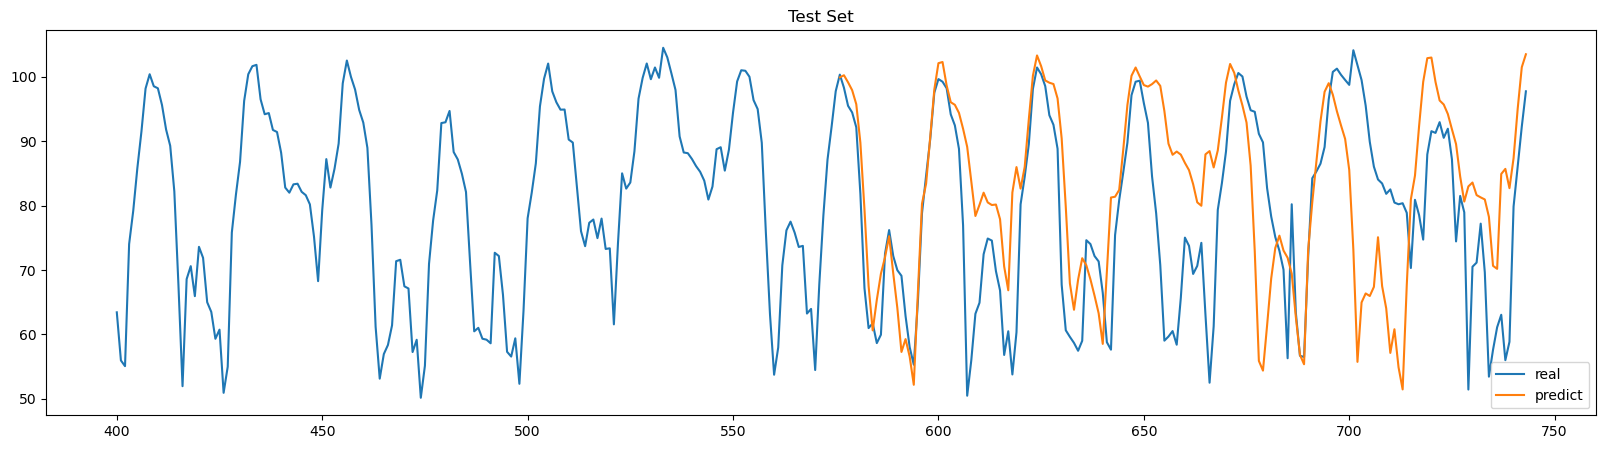

In [101]:
plt.figure(figsize=(20,5))
plt.plot(range(400,744), real[400:], label="real")
plt.plot(range(744-24*7,744), predict[-24*7:], label="predict")

plt.title("Test Set")
plt.legend()
plt.show()

- MAPE(mean absolute percentage error)
    - 결측 구간의 MAPE를 계산해서 정확히 어느정도 수치로 정확한지 계산
    - MAPE값도 결측치의 길이에 상관없이 대부분 좋은 값을 가지고 있음
    - 퍼센트 값을 가지며 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있음
    - 0~100% 사이의 값을 가져 이해하기 쉬우므로 성능 비교 해석이 가능

In [102]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPEval(predict[-24*7:],real[-24*7:])

15.478606237167197

---

- 하이퍼 파라미터만 다시 조정해서 모델 훈련

In [103]:
model1 = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)

In [104]:
# 다양한 최적화 알고리즘을 구현하는 패키지
import torch.optim as optim

learning_rate = 0.001
epoch = 3000
optimizer = optim.Adam(model1.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [105]:
from tqdm import tqdm

model1.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model1(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

100%|██████████| 3000/3000 [13:17<00:00,  3.76it/s, loss=0.00324]


In [106]:
predict1 = model1.predict(torch.tensor(train[-24*7*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real1 = data["평균속도"].to_numpy()

predict1 = min_max_scaler.inverse_transform(predict1.reshape(-1,1))
real1 = min_max_scaler.inverse_transform(real1.reshape(-1,1))

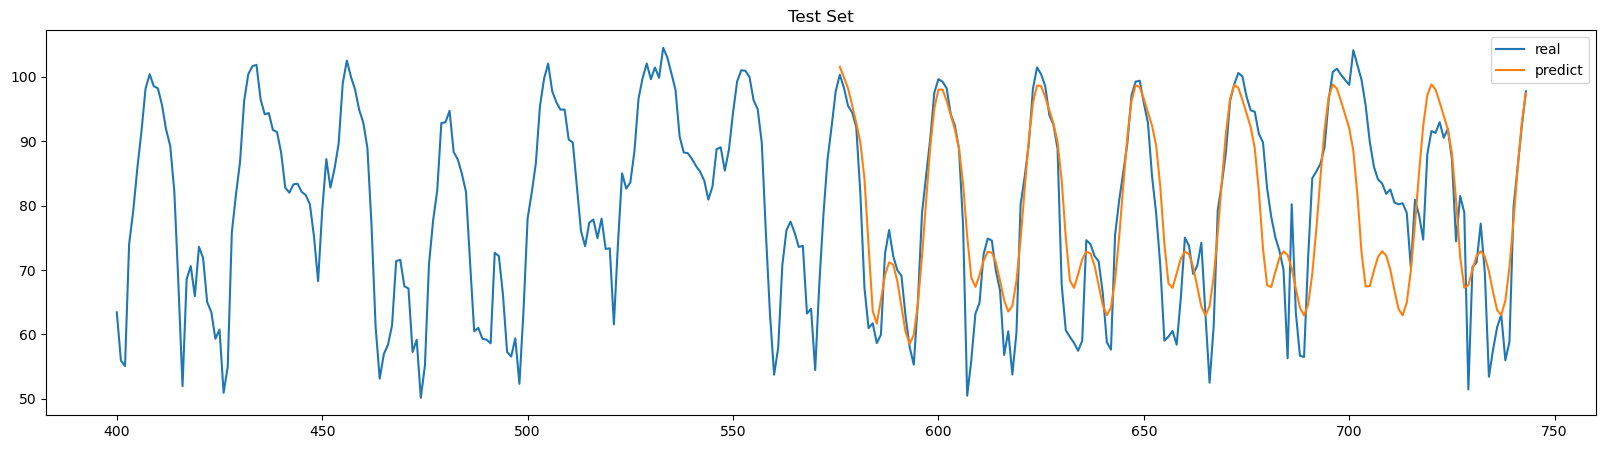

In [107]:
plt.figure(figsize=(20,5))
plt.plot(range(400,744), real1[400:], label="real")
plt.plot(range(744-24*7,744), predict1[-24*7:], label="predict")

plt.title("Test Set")
plt.legend()
plt.show()

In [108]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPEval(predict1[-24*7:],real1[-24*7:])

8.40561601931441

In [77]:
# from tqdm import tqdm

# best_list = []

# model1.train()
# for i in range(epoch):
#     total_loss = 0.0
#     for j in range(0, len(learning_rate)) :
#         lr = learning_rate[j]
#         optimizer = optim.Adam(model1.parameters(), lr = learning_rate[j])
#         for x,y in train_loader:
#             optimizer.zero_grad()
#             x = x.to(device).float()
#             y = y.to(device).float()
#             output = model(x, y, ow, 0.6).to(device)
#             loss = criterion(output, y)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.cpu().item()
#         best = total_loss/len(train_loader)
#         print("epoch : ", i, "------", "learning_rate : ", lr, "------", "loss = {0:.5f}".format(total_loss/len(train_loader)))
        
# best_list